## Facebook Prophet

In [28]:
import time
start_time = time.time()

In [29]:
data_csv="BTC-all.arff"
training_ratio=.7

In [30]:
#!pip install prophet

In [31]:
# check prophet version
import prophet
# print version number
print('Prophet %s' % prophet.__version__)

Prophet 1.1.4


In [32]:
# check matplotlib version
import matplotlib
# print version number
print('matplotlib %s' % matplotlib.__version__)

matplotlib 3.7.1


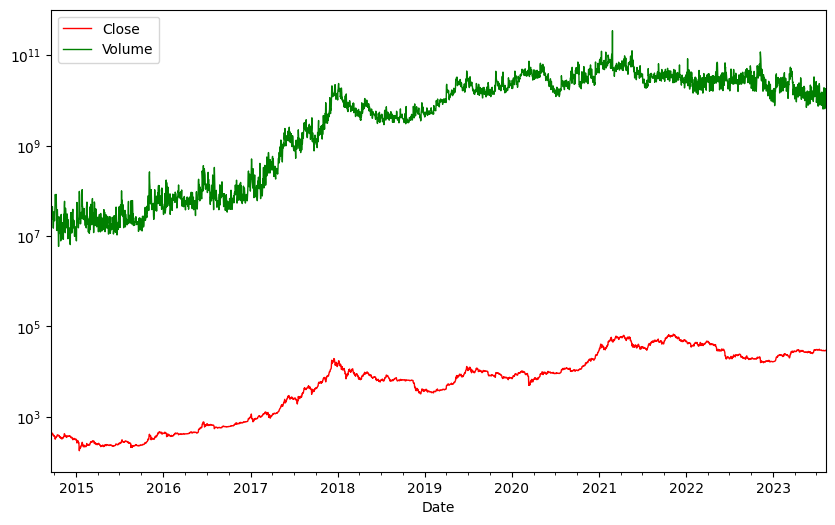

In [33]:
import pandas as pd
import os
from scipy.io import arff
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# load a dataset
data_file ='WekaData/'+data_csv
# BTC-N2Y.arff



# Load arff file
data, meta = arff.loadarff(data_file)
data_df = pd.DataFrame(data)

# Convert to pandas DataFrame
#data_df = pd.read_csv('bitcoin_hist.csv')
#data_df["Date"] =  pd.to_datetime(data_df["Date"], format="%m/%d/%Y")

data_df.plot(x='Date', y=['Close', 'Volume'], style=['r-', 'g-'], figsize=(10, 6), linewidth=1)  # for stock

# define the date format
date_form = mdates.DateFormatter('%Y')

# set the x-axis major locator to every even year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")

plt.show()

In [34]:
# evaluate prophet time series forecasting model on hold out dataset
from pandas import read_csv
from pandas import DataFrame
from prophet import Prophet
from matplotlib import pyplot
# preparing the data
df = data_df[['Date', 'Close', 'High', 'Low']].rename(columns={
    'Date':'ds', 'Close':'y', 'High': 'cap', 'Low': 'flr'})

# Assuming df is your DataFrame containing a 'y' column
df['y_1_step_ago'] = df['y'].shift(1)
df['y_2_steps_ago'] = df['y'].shift(2)
df['y_3_steps_ago'] = df['y'].shift(3)

# You may want to drop the rows where the new columns are NaN, which will be the case for the first few rows
df = df.dropna()

df.head()

,ds,y,cap,flr,y_1_step_ago,y_2_steps_ago,y_3_steps_ago
3,2014-09-20,408.903992,423.295990,389.882996,394.795990,424.440002,457.334015
4,2014-09-21,398.821014,412.425995,393.181000,408.903992,394.795990,424.440002
5,2014-09-22,402.152008,406.915985,397.130005,398.821014,408.903992,394.795990
6,2014-09-23,435.790985,441.557007,396.196991,402.152008,398.821014,408.903992
7,2014-09-24,423.204987,436.112000,421.131989,435.790985,402.152008,398.821014


In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# because it's multiplicative, so apply np.log
#dataset = np.log(dataset)

# Initialize a scaler for the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
# Z-score normalization is useful when the data has outliers or when the distribution of the data is not known. 
#scaler = StandardScaler() 

# Fit and transform the data to the scaler
# Split into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, train_size=training_ratio, shuffle=False)

# Fit the scaler to the training data and transform the training data
#train = scaler.fit_transform(train_data)
train_df = train_data.copy()
# Use the same scaler to transform the test data
#test = scaler.transform(test_data)
test_df = test_data.copy()
print(train_df.shape, test_df.shape)### Using Multiple Layer Perceptron

(2272, 7) (975, 7)


### Finding better parameters for Prophet

In [36]:
param_grid = {
    'seasonality_mode': ('additive', 'multiplicative'),
    'changepoint_prior_scale': [0.1, 0.5, 1.0],    
}

fourier_grid = {
    'name': ['myweek'], 
    'period': [7+7*i for i in range(10)],
    'fourier_order': [5+5*i for i in range(10)]
}

In [37]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import logging
for logger_name in logging.root.manager.loggerDict:
    if 'cmdstanpy' in logger_name:
        logging.getLogger(logger_name).setLevel(logging.WARNING)

# Split data into training and validation sets
ntrain_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=False)

best_params = None
lowest_rmse = float('inf')

# Iterate over all possible combinations of parameters
#for params in ParameterGrid(param_grid):
for fourier in ParameterGrid(fourier_grid):
        model = Prophet() #**params)
        model.add_seasonality(**fourier)
        model.add_regressor('y_1_step_ago')
        model.add_regressor('y_2_steps_ago')
        model.add_regressor('y_3_steps_ago')
        model.fit(ntrain_df)
        forecast = model.predict(val_df)
    
        # Compute the error metric of your choice (e.g., RMSE)
        mse = mean_squared_error(val_df['y'], forecast['yhat'])
        rmse = math.sqrt(mse)

        if rmse < lowest_rmse:
            lowest_rmse = rmse
            #best_params = params
            best_fourier = fourier
            print(f'current lowest rmse: {rmse}')

print(f'Best params: {best_fourier}')

current lowest rmse: 359.4564035089095
current lowest rmse: 358.4790109450689
current lowest rmse: 357.5980554878683
current lowest rmse: 356.9419067792819
current lowest rmse: 356.9197141967779
current lowest rmse: 356.72225893779097
current lowest rmse: 356.70236818810093
current lowest rmse: 354.43861589870795
Best params: {'fourier_order': 20, 'name': 'myweek', 'period': 63}


In [38]:
# define the model
model = Prophet()#**best_params)
model.add_regressor('y_1_step_ago')
model.add_regressor('y_2_steps_ago')
model.add_regressor('y_3_steps_ago')
model.add_seasonality(**best_fourier)
# fit the model
model.fit(train_df)

# use the model to make a forecast
train_forecast = model.predict(train_df)
# calculate MAE between expected and predicted values for december
train_y_true = train_df['y'].values
train_y_pred = train_forecast['yhat'].values
train_mse = mean_squared_error(train_y_true, train_y_pred)
train_mae = mean_absolute_error(train_y_true, train_y_pred)
print(f'prophet_train MSE: {train_mse:.4f}, RMSE: {math.sqrt(train_mse):.4f}, MAE: {train_mae:.4f}')


prophet_train MSE: 82164.8442, RMSE: 286.6441, MAE: 146.9245


In [39]:
test_forecast = model.predict(test_df)

# calculate MAE between expected and predicted values for december
test_y_true = test_df['y'].values
test_y_pred = test_forecast['yhat'].values
test_mse = mean_squared_error(test_y_true, test_y_pred)
test_mae = mean_absolute_error(test_y_true, test_y_pred)
print(f'test MSE: {test_mse:.4f}, RMSE: {math.sqrt(test_mse):.4f}, MAE: {test_mae:.4f}')


test MSE: 1896371.8304, RMSE: 1377.0882, MAE: 911.6073


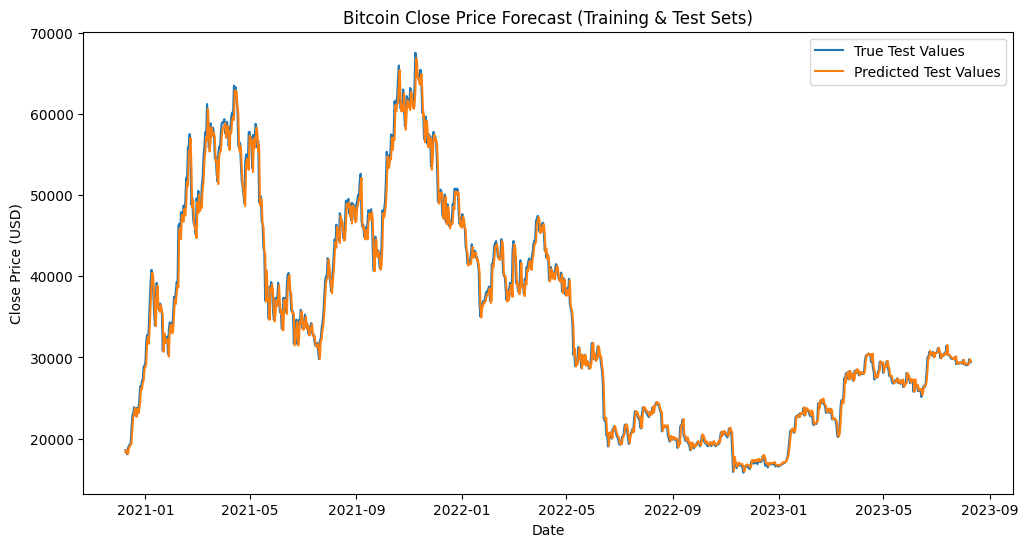

In [24]:

plt.figure(figsize=(12, 6))

# # Plotting the true values for the training set
# plt.plot(train_df['ds'], train_df['y'], label='True Training Values')

# # Plotting the predicted values for the training set
# plt.plot(train_df['ds'], train_forecast['yhat'], label='Predicted Training Values')

# Plotting the true values for the test set
plt.plot(test_df['ds'], test_df['y'], label='True Test Values')

# Plotting the predicted values for the test set
plt.plot(test_df['ds'], test_forecast['yhat'], label='Predicted Test Values')

plt.title('Bitcoin Close Price Forecast (Training & Test Sets)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

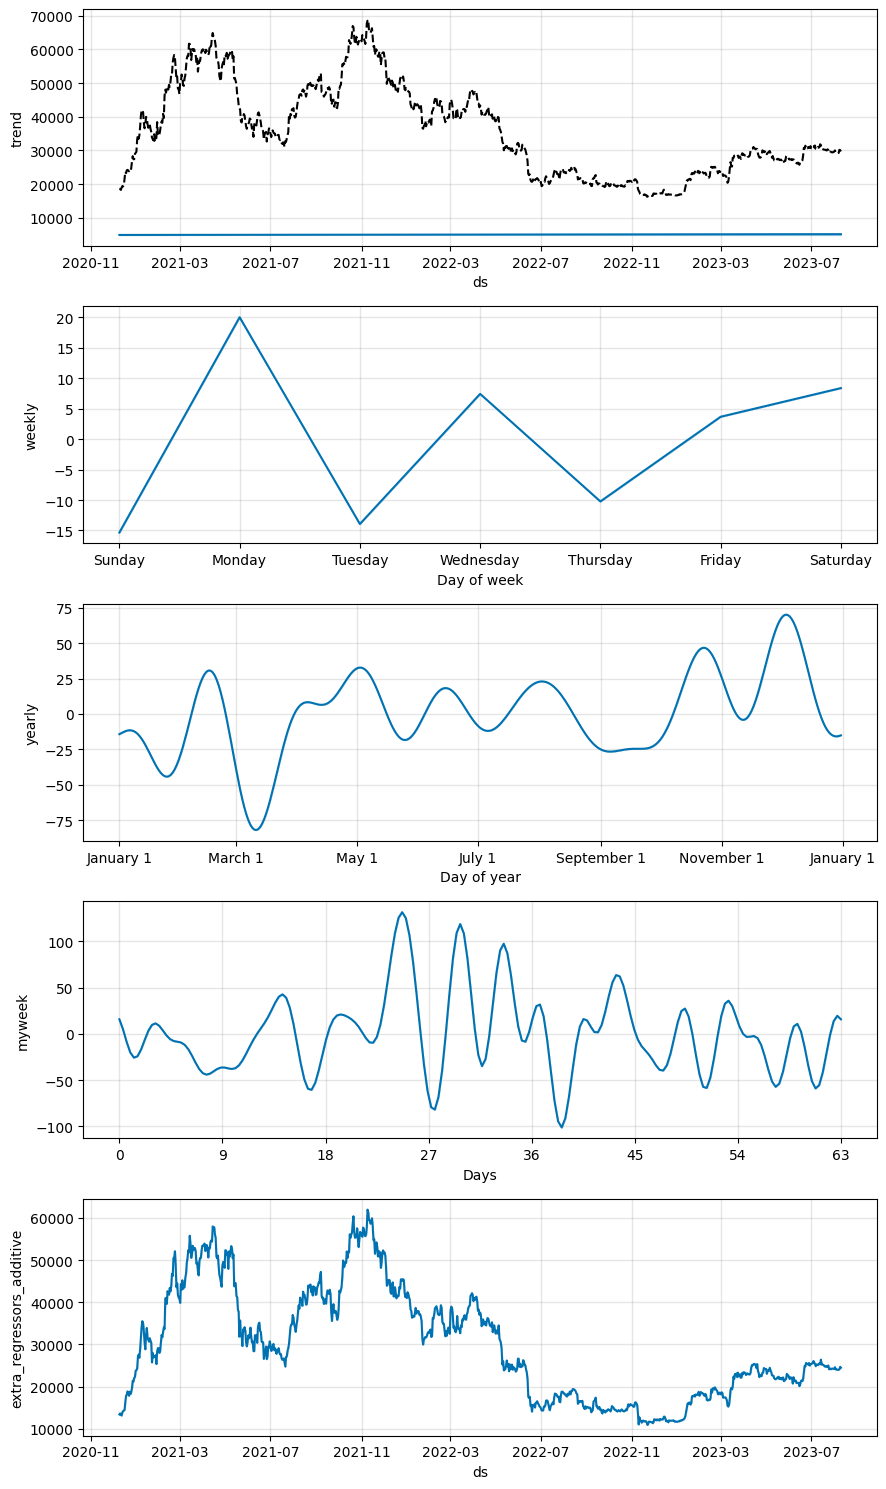

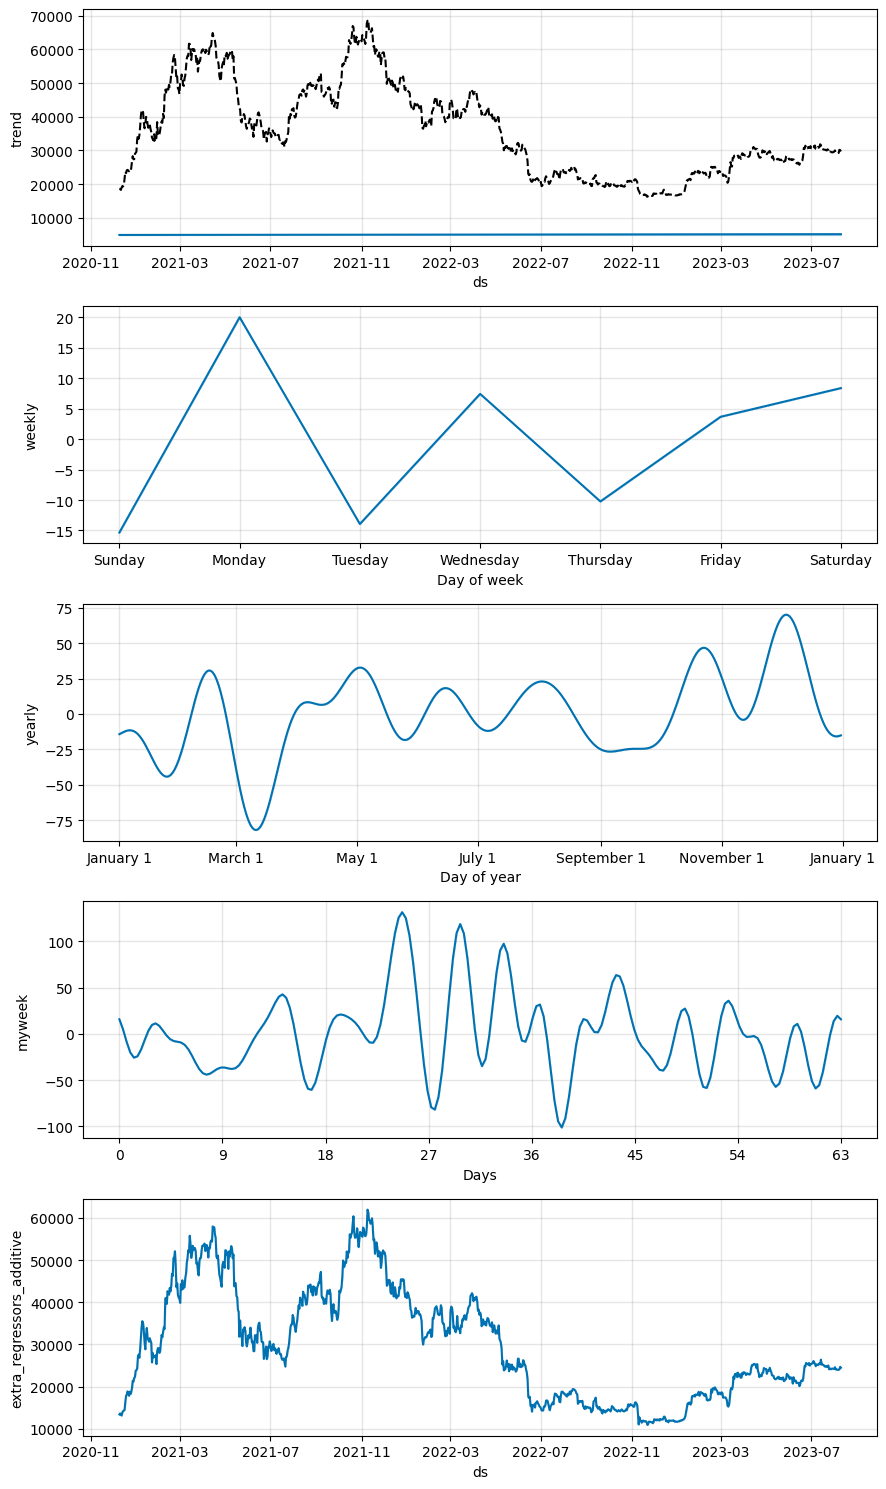

In [25]:
from prophet.plot import plot_components
#plot_components(model, train_forecast)
plot_components(model, test_forecast)


In [13]:
# evaluate prophet time series forecasting model on hold out dataset
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

In [15]:
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)

20:43:16 - cmdstanpy - INFO - Chain [1] start processing


           ds      y
91 1967-08-01  13434
92 1967-09-01  13598
93 1967-10-01  17187
94 1967-11-01  16119
95 1967-12-01  13713


20:43:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1336.813


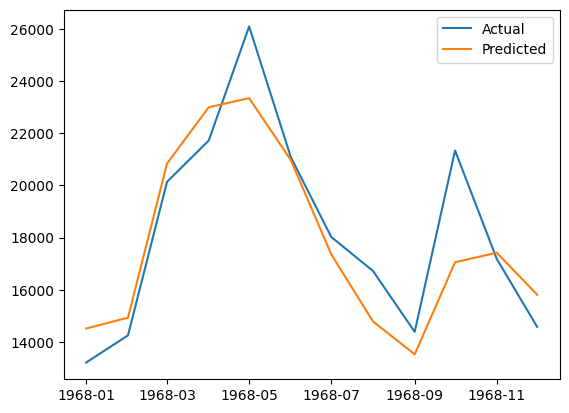

In [16]:
# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])
# create test dataset, remove last 12 months
train = df.drop(df.index[-12:])
print(train.tail())
# define the model
model = Prophet()
# fit the model
model.fit(train)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(future['ds'].tolist(), y_true, label='Actual')
pyplot.plot(future['ds'].tolist(), y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [17]:
end_time = time.time()
elapse = end_time-start_time
print(f'Total time: {elapse//60} minutes, {elapse%60:.2f} seconds.')

Total time: 0.0 minutes, 49.24 seconds.
